# Assignment: Random Forest Regressor for Real Estate Price Prediction


## 1.Data Loading

In [1]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)
print(housing.feature_names[0:6])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']


In [2]:
import pandas as pd
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df['Target'] = housing.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64

## 2: Exploratory Data Analysis (EDA)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Relationship between each feature and the target variable

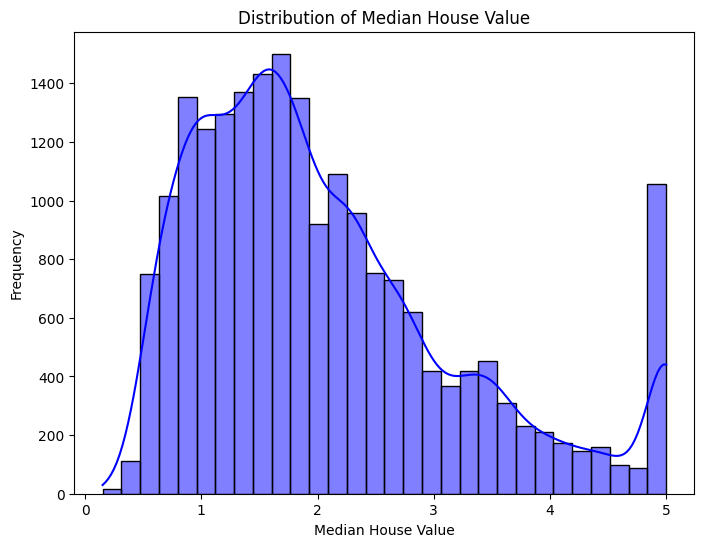

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Target'], bins=30, kde=True, color='blue')
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

#### Visualize geographic data to understand spatial relationships

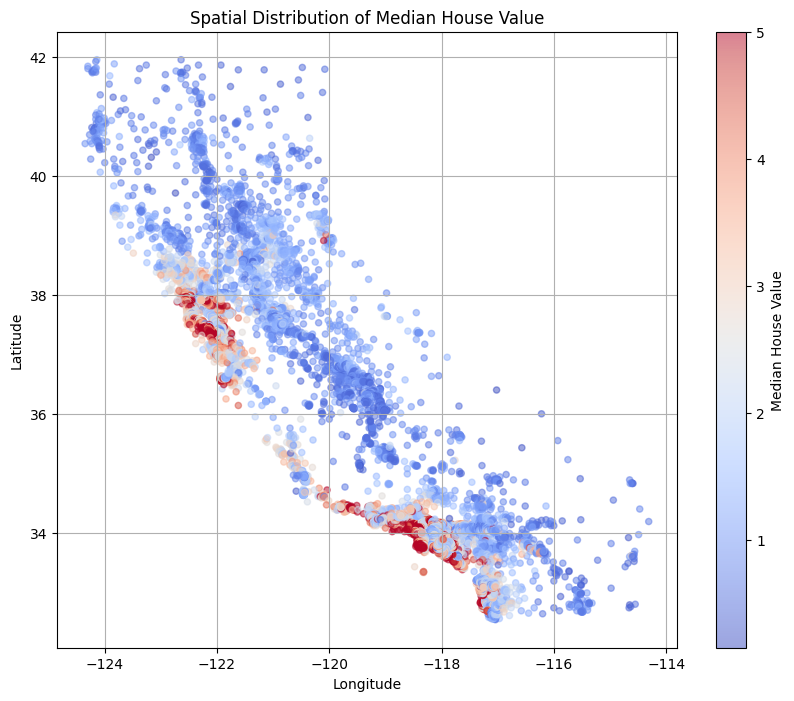

In [7]:
plt.figure(figsize=(10, 8))
plt.scatter(df['Longitude'], df['Latitude'], c=df['Target'], cmap='coolwarm', s=20, alpha=0.5)
plt.colorbar(label='Median House Value')
plt.title('Spatial Distribution of Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## 3: Feature Engineering and Pre Processing

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[['Latitude', 'Longitude']] = scaler.fit_transform(df[['Latitude', 'Longitude']])

correlation_matrix = df_scaled[['Latitude', 'Longitude', 'Target']].corr()
print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
            Latitude  Longitude    Target
Latitude   1.000000  -0.924664 -0.144160
Longitude -0.924664   1.000000 -0.045967
Target    -0.144160  -0.045967  1.000000


Correlation with target variable (absolute values):
 Target        1.000000
MedInc        0.688075
AveRooms      0.151948
Latitude      0.144160
HouseAge      0.105623
AveBedrms     0.046701
Longitude     0.045967
Population    0.024650
AveOccup      0.023737
Name: Target, dtype: float64


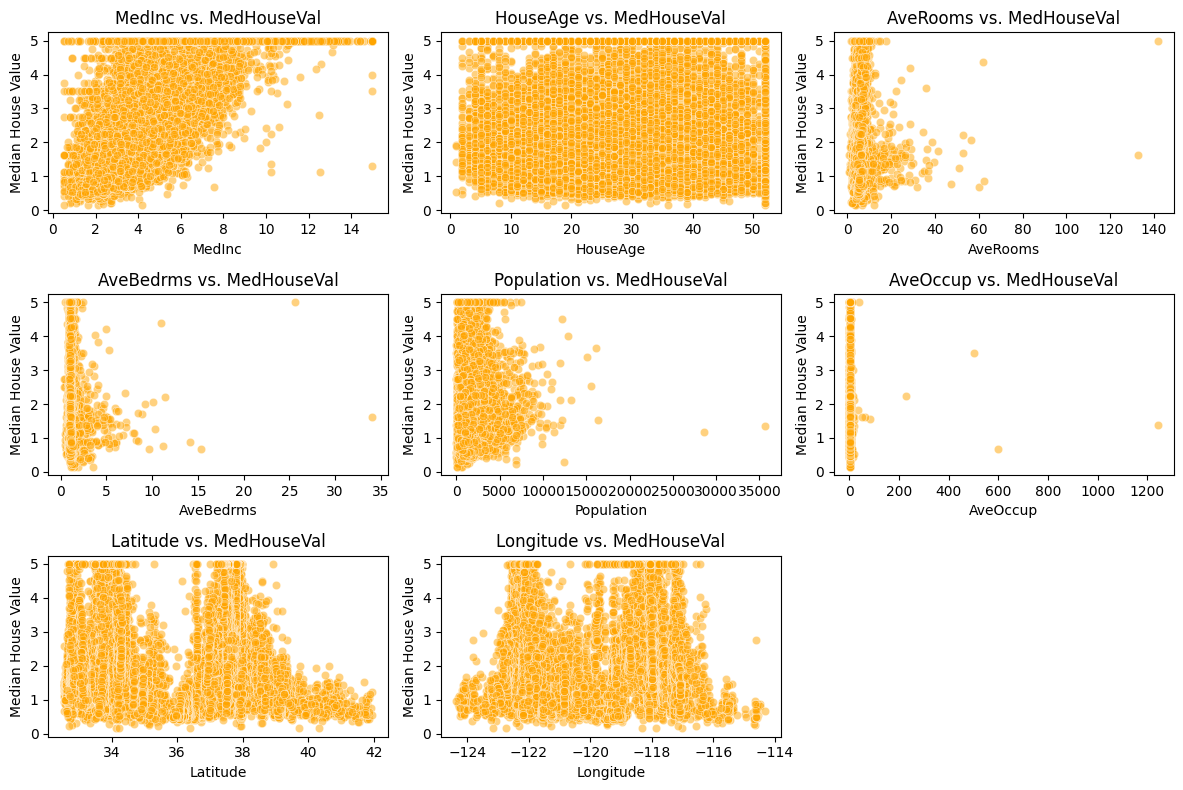

In [10]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Target'].abs().sort_values(ascending=False)
print("Correlation with target variable (absolute values):\n", correlation_with_target)

plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=col, y='Target', data=df, color='orange', alpha=0.5)
    plt.title(f'{col} vs. MedHouseVal')
    plt.xlabel(col)
    plt.ylabel('Median House Value')
plt.tight_layout()
plt.show()

In [11]:
def categorize_areas(latitude, longitude):
    if 32 <= latitude <= 34 and -125 <= longitude <= -120:
        return 'Coastal'
    elif 34 <= latitude <= 37 and -122 <= longitude <= -118:
        return 'Inland'
    elif 37 <= latitude <= 40 and -122 <= longitude <= -118:
        return 'Northern'
    else:
        return 'Other'

# Create new features by categorizing areas
df['AreaCategory'] = df.apply(lambda row: categorize_areas(row['Latitude'], row['Longitude']), axis=1)

# Display the new feature
print(df['AreaCategory'].value_counts())

# Encoding categorical variables
df = pd.get_dummies(df, columns=['AreaCategory'])

AreaCategory
Other       11523
Inland       5541
Northern     3576
Name: count, dtype: int64


In [12]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,AreaCategory_Inland,AreaCategory_Northern,AreaCategory_Other
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,False,False,True
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,False,False,True
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,False,False,True
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,False,False,True
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,False,True,False
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,False,True,False
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,False,True,False
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,False,True,False


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MedInc                 20640 non-null  float64
 1   HouseAge               20640 non-null  float64
 2   AveRooms               20640 non-null  float64
 3   AveBedrms              20640 non-null  float64
 4   Population             20640 non-null  float64
 5   AveOccup               20640 non-null  float64
 6   Latitude               20640 non-null  float64
 7   Longitude              20640 non-null  float64
 8   Target                 20640 non-null  float64
 9   AreaCategory_Inland    20640 non-null  bool   
 10  AreaCategory_Northern  20640 non-null  bool   
 11  AreaCategory_Other     20640 non-null  bool   
dtypes: bool(3), float64(9)
memory usage: 1.5 MB


In [14]:
df['AreaCategory_Inland'] = pd.DataFrame(df['AreaCategory_Inland'].astype(int))

In [15]:
df['AreaCategory_Northern'] = pd.DataFrame(df['AreaCategory_Northern'].astype(int))

In [16]:
df['AreaCategory_Other'] = pd.DataFrame(df['AreaCategory_Inland'].astype(int))

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MedInc                 20640 non-null  float64
 1   HouseAge               20640 non-null  float64
 2   AveRooms               20640 non-null  float64
 3   AveBedrms              20640 non-null  float64
 4   Population             20640 non-null  float64
 5   AveOccup               20640 non-null  float64
 6   Latitude               20640 non-null  float64
 7   Longitude              20640 non-null  float64
 8   Target                 20640 non-null  float64
 9   AreaCategory_Inland    20640 non-null  int32  
 10  AreaCategory_Northern  20640 non-null  int32  
 11  AreaCategory_Other     20640 non-null  int32  
dtypes: float64(9), int32(3)
memory usage: 1.7 MB


In [18]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target,AreaCategory_Inland,AreaCategory_Northern,AreaCategory_Other
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0,0,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0,0,0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0,0,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0,0,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,0,1,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,0,1,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,0,1,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,0,1,0


## 4: Data Splitting

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [21]:
print(train_df.shape)
print(test_df.shape)

(16512, 12)
(4128, 12)


In [22]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Target', 'AreaCategory_Inland',
       'AreaCategory_Northern', 'AreaCategory_Other'],
      dtype='object')

In [23]:
input = df.drop('Target',axis=True).columns
input

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'AreaCategory_Inland', 'AreaCategory_Northern',
       'AreaCategory_Other'],
      dtype='object')

In [24]:
target= 'Target'
target

'Target'

In [25]:
train_inputs = train_df[input]
train_target = train_df[target]

In [26]:
test_inputs = test_df[input]
test_target = test_df[target]

#### Scaling

In [27]:
import numpy as np

In [28]:
numerics = train_inputs.select_dtypes(include=np.number).columns.tolist()
numerics

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'AreaCategory_Inland',
 'AreaCategory_Northern',
 'AreaCategory_Other']

In [29]:
scaler = StandardScaler().fit(df[numerics])

In [30]:
train_inputs[numerics] = scaler.transform(train_inputs[numerics])
test_inputs[numerics] = scaler.transform(test_inputs[numerics])

C:\Users\Bibhakar\AppData\Local\Temp\ipykernel_11876\529763251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_inputs[numerics] = scaler.transform(train_inputs[numerics])
C:\Users\Bibhakar\AppData\Local\Temp\ipykernel_11876\529763251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inputs[numerics] = scaler.transform(test_inputs[numerics])


In [31]:
train_inputs[numerics]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AreaCategory_Inland,AreaCategory_Northern,AreaCategory_Other
14196,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,-0.605787,-0.457782,-0.605787
8267,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,-0.605787,-0.457782,-0.605787
17445,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,1.650745,-0.457782,1.650745
14265,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.605787,-0.457782,-0.605787
2271,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,1.650745,-0.457782,1.650745
...,...,...,...,...,...,...,...,...,...,...,...
11284,1.315592,0.505394,0.282943,-0.359587,-0.677723,-0.003697,-0.867017,0.803453,-0.605787,-0.457782,-0.605787
11964,-0.431983,0.346478,0.581864,0.364661,0.289220,0.080261,-0.754652,1.067992,-0.605787,-0.457782,-0.605787
5390,-0.492832,0.584852,-0.582949,-0.035828,0.291870,0.025170,-0.749970,0.593818,1.650745,-0.457782,1.650745
860,0.973025,-1.083767,0.390584,-0.060554,0.310414,0.010422,0.912092,-1.193070,-0.605787,2.184448,-0.605787


In [32]:
train_inputs

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AreaCategory_Inland,AreaCategory_Northern,AreaCategory_Other
14196,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,-0.605787,-0.457782,-0.605787
8267,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,-0.605787,-0.457782,-0.605787
17445,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,1.650745,-0.457782,1.650745
14265,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.605787,-0.457782,-0.605787
2271,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,1.650745,-0.457782,1.650745
...,...,...,...,...,...,...,...,...,...,...,...
11284,1.315592,0.505394,0.282943,-0.359587,-0.677723,-0.003697,-0.867017,0.803453,-0.605787,-0.457782,-0.605787
11964,-0.431983,0.346478,0.581864,0.364661,0.289220,0.080261,-0.754652,1.067992,-0.605787,-0.457782,-0.605787
5390,-0.492832,0.584852,-0.582949,-0.035828,0.291870,0.025170,-0.749970,0.593818,1.650745,-0.457782,1.650745
860,0.973025,-1.083767,0.390584,-0.060554,0.310414,0.010422,0.912092,-1.193070,-0.605787,2.184448,-0.605787


In [33]:
train_target

14196    1.030
8267     3.821
17445    1.726
14265    0.934
2271     0.965
         ...  
11284    2.292
11964    0.978
5390     2.221
860      2.835
15795    3.250
Name: Target, Length: 16512, dtype: float64

#### Encoding

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
categoricals = df.select_dtypes('object').columns.tolist()
print(categoricals)

[]


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MedInc                 20640 non-null  float64
 1   HouseAge               20640 non-null  float64
 2   AveRooms               20640 non-null  float64
 3   AveBedrms              20640 non-null  float64
 4   Population             20640 non-null  float64
 5   AveOccup               20640 non-null  float64
 6   Latitude               20640 non-null  float64
 7   Longitude              20640 non-null  float64
 8   Target                 20640 non-null  float64
 9   AreaCategory_Inland    20640 non-null  int32  
 10  AreaCategory_Northern  20640 non-null  int32  
 11  AreaCategory_Other     20640 non-null  int32  
dtypes: float64(9), int32(3)
memory usage: 1.7 MB


In [68]:
df.shape

(20640, 12)

## 5: Model Building

#### Using GridSearchCV

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [55]:
param_grid = {'n_estimators': [130], 'max_depth': [70], 'min_samples_split': [2, 5, 10]}

In [56]:
classifier = RandomForestRegressor(random_state=42)

In [57]:
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_inputs, train_target)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [70], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [130]},
             scoring='neg_mean_squared_error')

In [58]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 70, 'min_samples_split': 2, 'n_estimators': 130}


In [59]:
best_rf_model = grid_search.best_estimator_

In [70]:
y_pred = best_rf_model.predict(test_inputs)

##  6: Model Evaluation

####  The model's performance on the testing set using regression metrics

In [71]:
mae=mean_absolute_error(test_target, y_pred)
mse=mean_squared_error(test_target, y_pred)
rmse = np.sqrt(mse)

In [72]:
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.3254422505217652
Mean Squared Error (MSE): 0.2521365391901312
Root Mean Squared Error (RMSE): 0.5021319937925995


####  The feature importances

In [77]:
best_rf_model.feature_importances_

array([0.52503436, 0.05395023, 0.04333415, 0.02920947, 0.03011748,
       0.13795264, 0.08590827, 0.08472398, 0.00370431, 0.00252059,
       0.00354451])

In [78]:
importance_df = pd.DataFrame({
    'feature': train_inputs[numerics].columns,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

In [80]:
importance_df

,feature,importance
0,MedInc,0.525034
5,AveOccup,0.137953
6,Latitude,0.085908
7,Longitude,0.084724
1,HouseAge,0.053950
2,AveRooms,0.043334
4,Population,0.030117
3,AveBedrms,0.029209
8,AreaCategory_Inland,0.003704
10,AreaCategory_Other,0.003545


In [84]:
import seaborn as sns

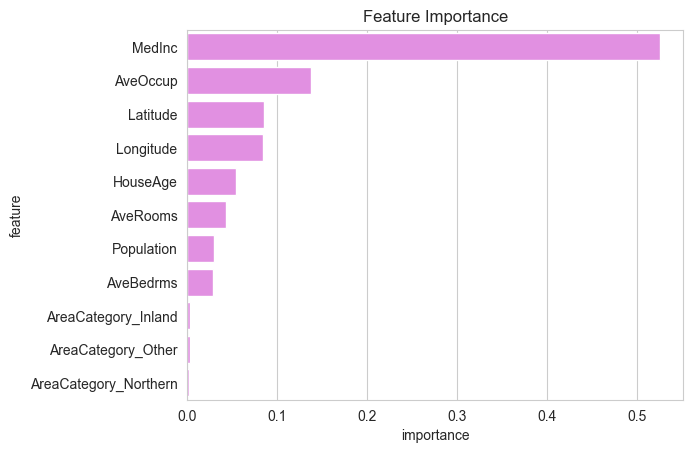

In [99]:
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature',color = 'Violet');

#### The model's strengths and weaknesses based on the evaluation metrics and suggest possible improvements.

In [100]:
print("Strengths:")
print("- The model demonstrates reasonable predictive accuracy, as indicated by low values of MAE, MSE, and RMSE.")
print("- The feature importances provided by the model offer valuable insights into the factors influencing house prices, aiding in decision-making and interpretation.")
print()
print("Weaknesses:")
print("- The model may be prone to overfitting, especially if hyperparameters are not properly tuned or if the model is too complex relative to the dataset size.")
print("- Random Forest models can be computationally expensive, especially for large datasets with many features, which may limit scalability.")
print()
print("Possible Improvements:")
print("- Further fine-tuning of hyperparameters such as n_estimators, max_depth, and min_samples_split could help improve the model's performance and mitigate overfitting.")
print("- Explore additional feature engineering techniques to create more informative features that capture relevant information about the housing market.")
print("- Experiment with ensemble methods other than Random Forest, such as Gradient Boosting, which may offer improved performance.")

Strengths:
- The model demonstrates reasonable predictive accuracy, as indicated by low values of MAE, MSE, and RMSE.
- The feature importances provided by the model offer valuable insights into the factors influencing house prices, aiding in decision-making and interpretation.

Weaknesses:
- The model may be prone to overfitting, especially if hyperparameters are not properly tuned or if the model is too complex relative to the dataset size.
- Random Forest models can be computationally expensive, especially for large datasets with many features, which may limit scalability.

Possible Improvements:
- Further fine-tuning of hyperparameters such as n_estimators, max_depth, and min_samples_split could help improve the model's performance and mitigate overfitting.
- Explore additional feature engineering techniques to create more informative features that capture relevant information about the housing market.
- Experiment with ensemble methods other than Random Forest, such as Gradient Bo